In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
from numpy import random
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

In [2]:
def xt(x, y, z, t):
    return (sigma*(y - x))

def yt(x, y, z, t):
    return (rho*x - y - x*z)

def zt(x, y, z, t):
    return (-1*(beta*z) + x*y)

In [3]:
def lorenz_ode_plot_components (x, y, z):
    plt.figure (figsize = (8.5,8.5))
    plt.plot ( t, x, linewidth = 1, color = 'b' )
    plt.grid ( True )
    plt.xlim([25, 35])
    plt.xlabel ( 'Time' )
    plt.ylabel ( 'x(t)' )
    plt.title ( 'Lorenz Time Series Plot' )
    
    plt.legend(['x'], loc = 1)
    plt.show ( )
    return 

In [4]:
def RungeKutta4(xt,yt,zt,n = 10000, T = 100):
    
    x = np.zeros(n+1)
    y = np.zeros(n+1)
    z = np.zeros(n+1)
    t = np.zeros(n+1)
    
    x[0] = 0.0
    y[0] = 1.0
    z[0] = 0.0
    t[0] = 0
    dt = T/float(n) #0.01
    
    for k in range (n):
    
        t[k+1] = t[k] + dt
        
        k1 = xt(x[k], y[k], z[k], t[k])
        l1 = yt(x[k], y[k], z[k], t[k])
        m1 = zt(x[k], y[k], z[k], t[k])

        k2 = xt((x[k] + 0.5*k1*dt), (y[k] + 0.5*l1*dt), (z[k] + 0.5*m1*dt), (t[k] + dt/2))
        l2 = yt((x[k] + 0.5*k1*dt), (y[k] + 0.5*l1*dt), (z[k] + 0.5*m1*dt), (t[k] + dt/2))
        m2 = zt((x[k] + 0.5*k1*dt), (y[k] + 0.5*l1*dt), (z[k] + 0.5*m1*dt), (t[k] + dt/2))

        k3 = xt((x[k] + 0.5*k2*dt), (y[k] + 0.5*l2*dt), (z[k] + 0.5*m2*dt), (t[k] + dt/2))
        l3 = yt((x[k] + 0.5*k2*dt), (y[k] + 0.5*l2*dt), (z[k] + 0.5*m2*dt), (t[k] + dt/2))
        m3 = zt((x[k] + 0.5*k2*dt), (y[k] + 0.5*l2*dt), (z[k] + 0.5*m2*dt), (t[k] + dt/2))

        k4 = xt((x[k] + k3*dt), (y[k] + l3*dt), (z[k] + m3*dt), (t[k] + dt))
        l4 = yt((x[k] + k3*dt), (y[k] + l3*dt), (z[k] + m3*dt), (t[k] + dt))
        m4 = zt((x[k] + k3*dt), (y[k] + l3*dt), (z[k] + m3*dt), (t[k] + dt))

        x[k+1] = x[k] + (dt*(k1 + 2*k2 + 2*k3 + k4) / 6)
        y[k+1] = y[k] + (dt*(l1 + 2*l2 + 2*l3 + l4) / 6)
        z[k+1] = z[k] + (dt*(m1 + 2*m2 + 2*m3 + m4) / 6)

    return x, y, z, t

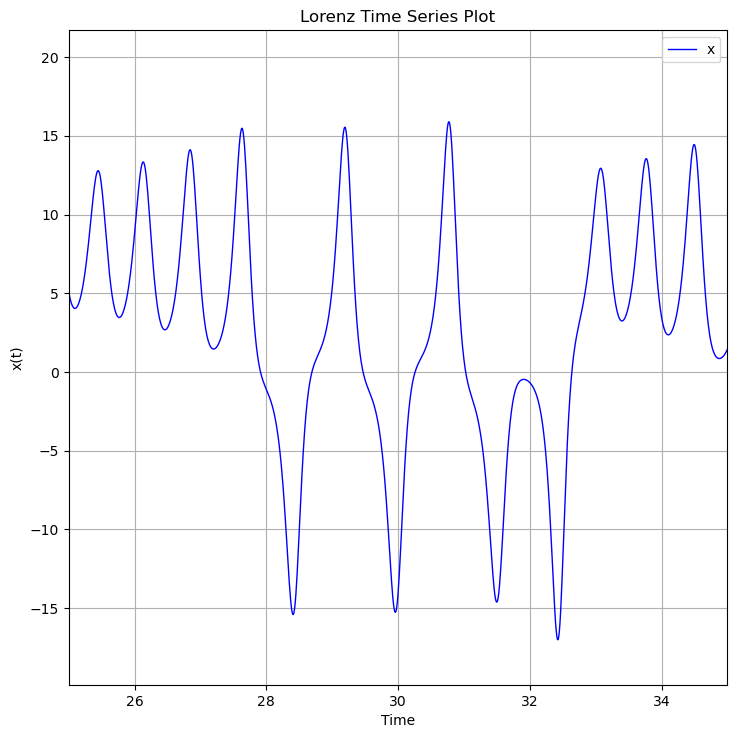

In [5]:
# Значения при которых хаотическое поведение
sigma = 10.0
beta = 8.0/3.0
rho = 28.0

x, y, z, t = RungeKutta4(xt,yt,zt)

lorenz_ode_plot_components (x,y,z)

#### Генерация данных для нашей системы

In [6]:
np.random.seed(0)
l = 1000

T = np.linspace(25, 35, num=l)
X = x[2500 : 3500]

T_train, T_test, X_train, X_test = train_test_split(T, X, 
                                                    test_size=10, 
                                                    random_state=0)

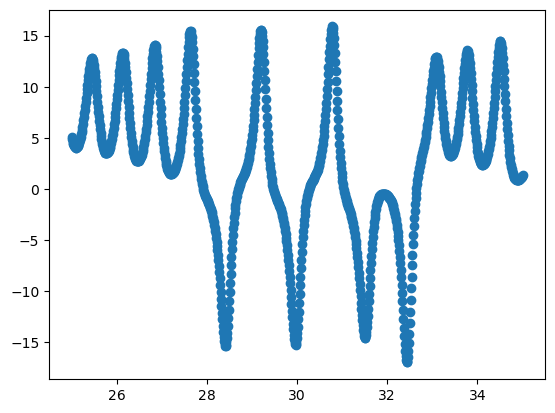

In [7]:
plt.plot(T, X, 'o')
    
plt.show()

#### Запуск SVR без подстройки коэффициентов:

In [8]:
model = SVR(kernel='rbf')
_ = model.fit(T_train.reshape(-1,1), X_train)

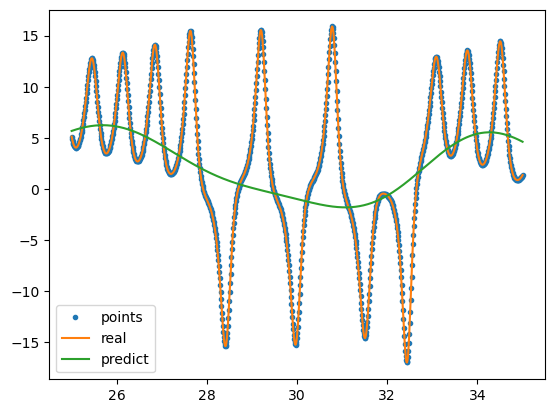

In [9]:
plt.plot(T, X, '.', label='points')
plt.plot(T, x[2500 : 3500], label='real')
plt.plot(T, model.predict(T.reshape(-1,1)), label='predict')

plt.legend(loc='best')
plt.show()

In [10]:
# Алгоритм подбора коэффициентов
def COA (T_train, X_train, N, MSEd):
    z = np.random.rand(3)
    a = [2**(-5), 2**(-15), 2**(-12)]
    b = [2**15, 2**5, 1]
    anew = [2**(-5), 2**(-15), 2**(-12)]
    bnew = [2**15, 2**5, 1]
    optimx = np.zeros(3);
    K = 1;
    error = 1000.0
    while (K<N and error>MSEd):
        for i in range(3):
            z[i] = 4*z[i]*(1-z[i])
            x[i] = anew[i]+(bnew[i]-anew[i])*z[i]
        newerr = LorenzSVRError(T_train, X_train, x[0], x[1], x[2])
        if (newerr < error):
            error = newerr
            optimx[0] = x[0]
            optimx[1] = x[1]
            optimx[2] = x[2]
        K = K+1
        for i in range(3):
            anew[i] = optimx[i]-(1/(K+1))*(bnew[i]-anew[i])
            if (anew[i]<a[i]):
                anew[i] = a[i]
            bnew[i] = optimx[i]+(1/(K+1))*(bnew[i]-anew[i])
            if (bnew[i]>b[i]):
                bnew[i] = b[i]
    return x[0], x[1], x[2], error

In [11]:
# Подсчет ошибки
def LorenzSVRError (T_train, X_train, Cval, gval, epsval):
    model = SVR(kernel='rbf', C=Cval, epsilon=epsval, gamma=gval)
    _ = model.fit(T_train.reshape(-1,1), X_train)
    return mean_squared_error(x[2500 : 3500], model.predict(T.reshape(-1,1)))

#### Результат работы SVR с подобранными коэффициентами

In [12]:
Cval, g, eps, error = COA(T_train, X_train, 10, 0.001)

model = SVR(kernel='rbf', C=Cval, epsilon=eps, gamma=g)
_ = model.fit(T_train.reshape(-1,1), X_train)

#### Найденные коэффициенты и достигнутая ошибка:

In [13]:
print('C = : {}'.format(Cval))
print('epsilon = : {}'.format(eps))
print('gamma = : {}'.format(g))
print('Точность: {}'.format(error))

C = : 30824.035210295722
epsilon = : 0.26141525351487943
gamma = : 10.236429899798651
Точность: 0.039925957115113674


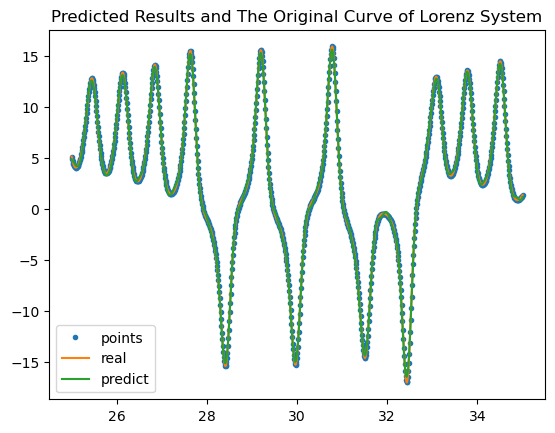

In [14]:
plt.plot(T, X, '.', label='points')
plt.plot(T, x[2500 : 3500], label='real')
plt.plot(T, model.predict(T.reshape(-1,1)), label='predict')

plt.legend(loc='best')
plt.title ( 'Predicted Results and The Original Curve of Lorenz System' )
plt.show()

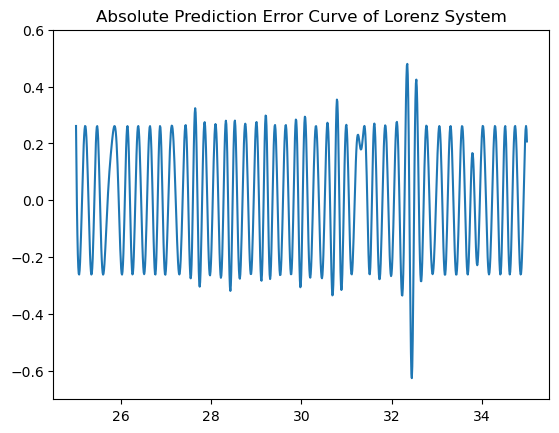

In [15]:
plt.plot(T, np.subtract(x[2500 : 3500], model.predict(T.reshape(-1,1))))

plt.title ( 'Absolute Prediction Error Curve of Lorenz System' )
plt.ylim([-0.7, 0.6])
plt.show()